In [1]:
# import tensorflow as tf
import functools
import jax.numpy as jnp
import os
import json
import numpy as np

import jax
from jax.experimental import optimizers
from src import data, model_utils
from renn.rnn import cells, unroll, network
from renn import utils
import renn

from data_processing import analysis_utils as au

import tensorflow_datasets as tfds

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
%matplotlib inline

## Model and data loading

In [377]:
data_folder = 'results/yelp/3class/UGRNN_eta_0.01_L2_0.01_run_47ruawz6/'

In [378]:
with open(os.path.join(data_folder, 'config.json')) as f:
    config = json.load(f)

### Get data

In [379]:
encoder, train_dset, test_dset = data.get_dataset(config['data'])

In [380]:
config['data']

{'dataset': 'yelp', 'batch_size': 256, 'max_pad': 800, 'num_classes': 3}

### Get model

In [381]:
cell = model_utils.get_cell(config['model']['cell_type'],
                            num_units=config['model']['num_units'])

In [382]:
init_fun, apply_fun, emb_apply, readout_apply = network.build_rnn(encoder.vocab_size,
                                                                  config['model']['emb_size'],
                                                                  cell,
                                                                  num_outputs=config['model']['num_outputs'])
emb_init, emb_apply = renn.embedding(encoder.vocab_size, 
                                     config['model']['emb_size'])

In [383]:
network_params = model_utils.load_params(os.path.join(data_folder, 'final_params'))
emb_params, rnn_params, readout_params = network_params

In [384]:
optimizers.l2_norm(rnn_params)

DeviceArray(11.213196, dtype=float32)

## Analysis

### PCA of hidden states

In [385]:
test_batch = next(tfds.as_numpy(test_dset))

In [386]:
visited_states = {'original': au.rnn_states(cell, test_batch, rnn_params, emb_params, emb_apply)}
final_states = {'original': au.rnn_end_states(cell, test_batch, rnn_params, emb_params, emb_apply)}

In [387]:
PCA_objects = {'visited': au.PCA_rnn(),
               'final': au.PCA_rnn(),
               'fixed': au.PCA_rnn()}

PCA_objects['visited'].fit(np.vstack(visited_states['original']))
PCA_objects['final'].fit(np.vstack(final_states['original']))

PCA_rnn()

In [388]:
visited_states['transformed'] = [PCA_objects['visited'].transform(v) for v in visited_states['original']]
final_states['transformed'] = [PCA_objects['visited'].transform(f) for f in final_states['original']]

In [389]:
dimensionalities = {'visited': au.cumulative_var_explained(PCA_objects['visited']),
                    'final': au.cumulative_var_explained(PCA_objects['final'])}

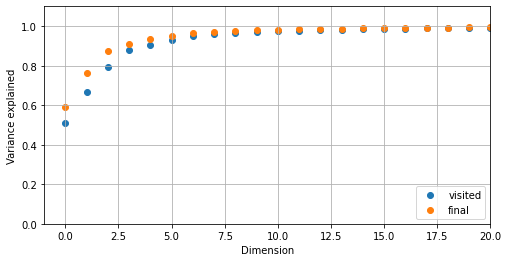

In [390]:
f = au.plot_varexp(dimensionalities)

In [391]:
coordinates = ['original', 'transformed']

visited_by_value = {c: au.states_by_value(visited_states[c], test_batch['labels'], config['data']['num_classes']) for c in coordinates}
final_by_value = {c: au.states_by_value(final_states[c], test_batch['labels'], config['data']['num_classes']) for c in coordinates}

### Visualizing trajectories in 2D PCA plane

In [392]:
initial_state_vector = {'original': cell.get_initial_state(rnn_params, batch_size=1)}
initial_state_vector['transformed'] = PCA_objects['visited'].transform(initial_state_vector['original'])

In [393]:
readout_vectors = {'original': readout_params[0].T}
readout_vectors['transformed'] = PCA_objects['visited'].transform_no_mean(readout_vectors['original'])

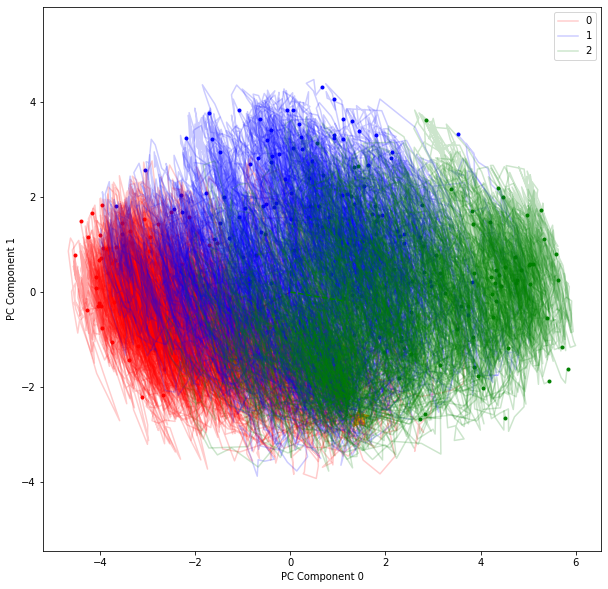

In [394]:
plt.figure(figsize=(10,10))
au.plot_states(visited_by_value['transformed'], 
            readout_vectors['transformed'], 
            initial_state_vector['transformed'], 
            pc_dimensions=[0,1])

### Find the fixed points

In [395]:
fixed_points_, loss_hist, fp_losses = au.fixed_points(cell,
                                                    rnn_params,
                                                    visited_states['original'],
                                                    tolerance=9e-5,
                                                    embedding_size=config['model']['emb_size'],
                                                    noise_scale=0.5,
                                                    decimation_factor=10
                                                    )

 37%|███▋      | 3663/10000 [00:03<00:05, 1097.21it/s]


Text(0, 0.5, 'Fixed point loss')

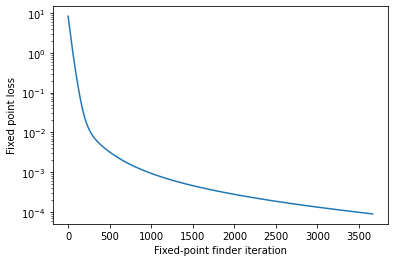

In [396]:
plt.semilogy(loss_hist)
plt.xlabel('Fixed-point finder iteration')
plt.ylabel('Fixed point loss')

In [397]:
fixed_points = {'original': fixed_points_,
                'transformed': PCA_objects['visited'].transform(fixed_points_)}

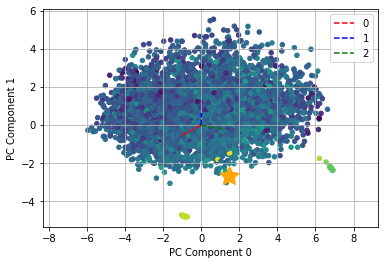

In [398]:
au.plot_fp_2d(fixed_points['transformed'],
              fp_losses,
              readout_vectors['transformed'],
              initial_state_vector['transformed'], 
              pc_dimensions=[0,1])

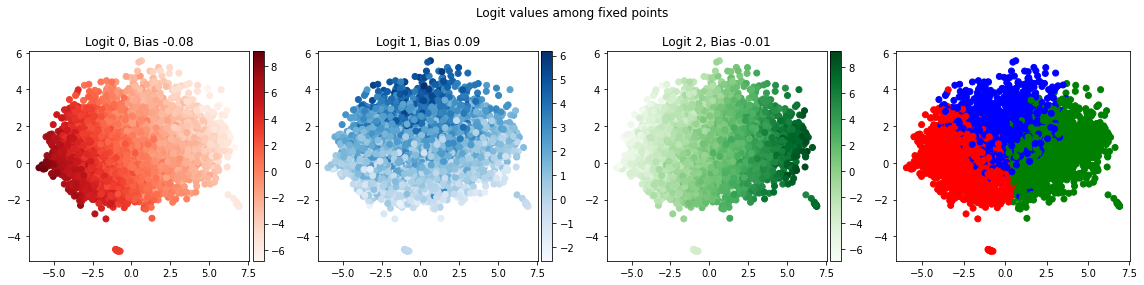

In [399]:
au.plot_logits(readout_apply, readout_params, fixed_points['original'], PCA_objects['visited']);

In the above plots, we calculate the logit by directly running the readout function.  As a sanity check, and a check that our lower-dimensional representation is capturing well-enough the relevant details, we can also calculate the logits by dot-producting the projected readout vector and the projected point.

#### Dimensionality of the fixed point manifold

In [265]:
PCA_objects['fixed'].fit(fixed_points['original'])
dimensionalities['fixed']= au.cumulative_var_explained(PCA_objects['fixed'])

(-1.0, 8.0)

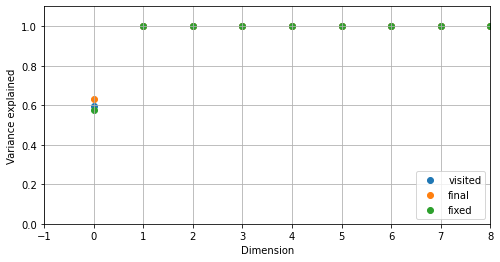

In [266]:
f = au.plot_varexp(dimensionalities)
plt.xlim(-1, 8)

### Check alignment of the fixed point PCA vectors with the hidden state PCA vectors

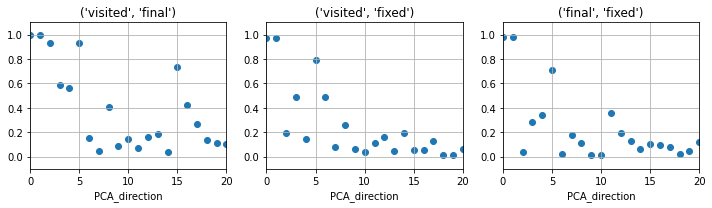

In [267]:
f = au.plot_alignment(PCA_objects)

### Fixed-point selector and Recurrent Jacobian

In [268]:
fixed_point_index = 0

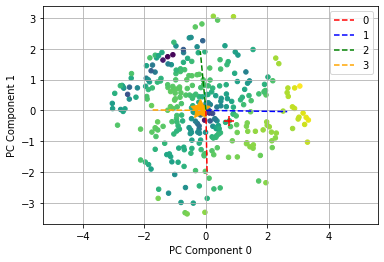

In [269]:
au.plot_fp_2d(fixed_points['transformed'],
              fp_losses,
              readout_vectors['transformed'],
              initial_state_vector['transformed'], 
              pc_dimensions=[0,1],
              point_to_highlight=fixed_point_index)

In [270]:
J_hh = cell.rec_jac(rnn_params, 
             jnp.zeros(config['model']['emb_size']), 
             fixed_points['original'][fixed_point_index])

R, E, L = renn.eigsorted(J_hh)

Text(0, 0.5, 'imag')

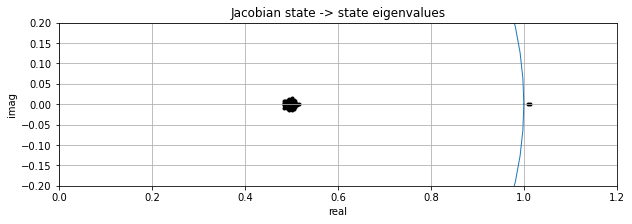

In [271]:
plt.figure(figsize=(10, 3))
plt.grid()
plt.scatter(np.real(E), np.imag(E), c='k', marker='.')
plt.xlim(0., 1.2)
plt.ylim(-0.2, 0.2)

t = np.linspace(0,np.pi*2,100)
plt.plot(np.cos(t), np.sin(t), linewidth=1)

plt.title('Jacobian state -> state eigenvalues')
plt.xlabel('real')
plt.ylabel('imag')

### Individual word analysis

In [1472]:
initial_pts = fixed_points[::3]
l = fp_losses[::3]

In [1473]:
encoder.subwords

['the_',
 ', ',
 'a_',
 'to_',
 'of_',
 's_',
 'in_',
 'and_',
 'on_',
 '. ',
 'for_',
 '39',
 ' #',
 '  ',
 'that_',
 ' - ',
 'The_',
 'ing_',
 'with_',
 ' (',
 'as_',
 'its_',
 'is_',
 'at_',
 'ed_',
 'has_',
 'an_',
 'by_',
 'said_',
 'from_',
 'it_',
 'd_',
 'his_',
 'was_',
 'will_',
 'Reuters',
 ') - ',
 'e_',
 'after_',
 'A_',
 'be_',
 'have_',
 '; ',
 'y_',
 'their_',
 't_',
 'are_',
 'quot',
 'new_',
 'AP',
 'over_',
 'lt',
 'gt',
 'US_',
 'first_',
 'he_',
 ') ',
 'up_',
 'but_',
 'Inc',
 ' \\$',
 'more_',
 'two_',
 ': ',
 'this_',
 'n_',
 'were_',
 'out_',
 'into_',
 ' -- ',
 'who_',
 'against_',
 'last_',
 'not_',
 'one_',
 'ly_',
 'er_',
 'they_',
 'than_',
 'been_',
 'about_',
 'Corp',
 'had_',
 'es_',
 'or_',
 'Monday_',
 'Thursday_',
 'would_',
 'Wednesday_',
 'company_',
 'Tuesday_',
 'year',
 'r_',
 'which_',
 'New_',
 'on',
 'year_',
 'United_',
 'when_',
 'yesterday_',
 'ing',
 'could_',
 'ng_',
 'three_',
 'ed',
 'time_',
 'NEW_',
 'Friday_',
 'million_',
 'the',
 

In [1474]:
word = 'billion '
encoder.encode(word)

[198]

In [1475]:
word_input_ = emb_apply(emb_params, encoder.encode(word))
word_input = jnp.repeat(word_input_, initial_pts.shape[0], axis=0)

In [1476]:
transformed = PCA_objects['all_states'].transform(initial_pts).T

(-2.0, 2.0)

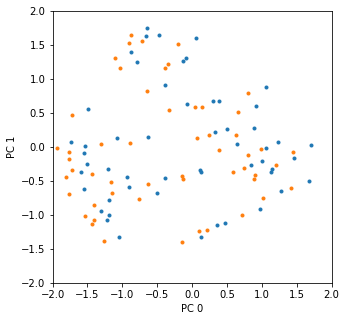

In [1477]:
plt.figure(figsize=(5,5))
final_pts = initial_pts
plt.scatter(transformed[0], transformed[1], marker='.')

for i in range(1):
    final_pts = cell.batch_apply(rnn_params, word_input, final_pts)
    transformed_final = PCA_objects['all_states'].transform(final_pts).T
    
#     if i % 5 == 4:
    plt.scatter(transformed_final[0], transformed_final[1], marker='.')
    

plt.xlabel("PC 0")
plt.ylabel("PC 1")
plt.xlim(-2,2)
plt.ylim(-2,2)
# plt.axis('equal')

In [1478]:
dirs = []
for i, p in enumerate(initial_pts):
    J_xh = cell.inp_jac(rnn_params, 
                        jnp.zeros(config['model']['emb_size']), 
                        p)
    jacobian_direction = PCA_objects['all_states'].transform_no_mean(jnp.dot(J_xh, word_input_.T).T)
#     jacobian_direction = PCA_objects['all_states'].transform(jnp.dot(J_xh, word_input_.T).T)
    dirs.append(jacobian_direction[0])
dirs = np.array(dirs)

In [1371]:
J_fn = lambda p : cell.rec_jac(rnn_params, jnp.zeros(config['model']['emb_size']), p)
top_evecs = au.top_evecs(J_fn, initial_pts)

KeyboardInterrupt: 

In [1479]:
def in_plane_magnitudes(eigenvectors, PCA_obj, dimensions_to_keep=2):
    """
    eigenvectors is shape (n_points, evec_dimension, n_eigenvects)
    
    """
        
    mags = []
    
    for i in range(len(eigenvectors)):
        full_norms = np.linalg.norm(eigenvectors[i,:,:],axis=0)
        transformed = PCA_obj.transform_no_mean(np.real(eigenvectors[i,:,:].T))[:,:dimensions_to_keep]
        plane_norms = np.linalg.norm(transformed,axis=1)
        
        mags.append(plane_norms/full_norms)
    return np.array(mags)
        
        

In [1480]:
plt.hist(in_plane_magnitudes(top_evecs, PCA_objects['all_states'], 2).flatten())

ValueError: shapes (2,256) and (512,512) not aligned: 256 (dim 1) != 512 (dim 0)

In [1481]:
top_evecs.shape

(104, 256, 2)

In [1482]:
top_eig = np.array([PCA_objects['all_states'].transform_no_mean(np.real(t.T)) for t in top_evecs])

ValueError: shapes (2,256) and (512,512) not aligned: 256 (dim 1) != 512 (dim 0)

In [ ]:
initial_states = [transformed[0], transformed[1]]
final_states = np.array([transformed_final[0], transformed_final[1]])
# jacobian_dirs = [dirs[0], dirs[1]]

deltas = final_states - np.array(initial_states)

plt.figure(figsize=(15,15))
# plt.quiver(initial_states[0], initial_states[1], deltas[0], deltas[1], scale=1, units='xy', color='blue')
# plt.quiver(initial_states[0], initial_states[1], dirs[:,0], dirs[:,1], scale=1, units='xy', color='orange')
plt.axis('equal')

s = np.mean(deltas**2)

i = encoder.encode(word)[0]

plt.title(f'Word: {word} (Index {i}) \n Mean deflection in plane: {s:0.2f}', fontsize=14)
plt.xlabel('PC 0 component')
plt.ylabel('PC 1 component')

plt.scatter(initial_states[0], initial_states[1], c = np.log10(l), marker='.')

scale=1.

for i in range(top_eig.shape[0]):
    plt.quiver([initial_states[0][i]], [initial_states[1][i]], [top_eig[i][0][0]], [top_eig[i][0][1]], scale=3, units='xy')
    plt.quiver([initial_states[0][i]], [initial_states[1][i]], [top_eig[i][1][0]], [top_eig[i][1][1]], scale=3, units='xy')


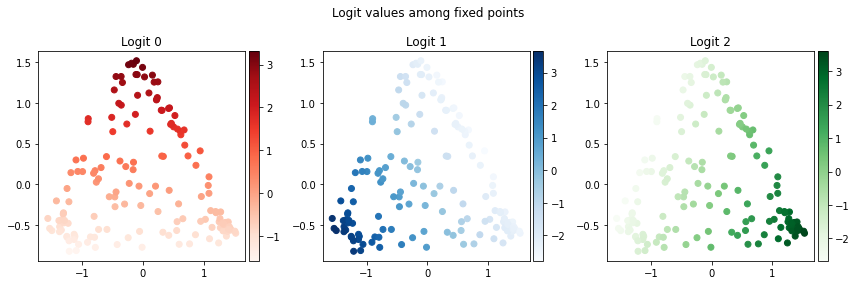

In [1136]:
plot_logits(readout_apply, readout_params, fixed_points, PCA_objects['all_states']);